# Brief [In Progress]

OilyGiant mining company is looking to find the best place for a new well. The company provided steps to choose the location:

- Step 1: Collect the oil well parameters in the selected region: oil quality and volume of reserves;

- Step 2: Build a model for predicting the volume of reserves in the new wells;

- Step 3: Pick the oil wells with the highest estimated values;

- Step 4: Pick the region with the highest total profit for the selected oil wells.


Additional:

- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.

- The budget for development of 200 oil wells is 100 USD million.

- One barrel of raw materials brings 4.5 USD of revenue. The revenue from one unit of product is 4,500 dollars (volume of reserves is in the thousands of barrels).

- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

- The data is synthetic: contract details and well characteristics are not disclosed.


# Data

We have data on oil samples from three regions and the parameters of each oil well in the region are already known.

Geological exploration data for the three regions are stored in files:
- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

Features:
- `id`: unique oil well identifier
- `f0`, `f1`, `f2`: three features of points (their specific meaning is unimportant, but the features themselves are significant)
- `product`: volume of reserves in the oil well (thousand barrels)


# Task

Build a model that will help to pick the region with the highest profit margin then analyze potential profit and risks using Bootstrapping techniques.


**Libraries**

Common

In [492]:
import pandas as pd
import numpy as np
from math import floor, log
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns


Sklearn

In [493]:
from sklearn.linear_model import LinearRegression, SGDRegressor,BayesianRidge, ElasticNet
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.model_selection import check_cv, cross_validate, cross_val_predict, cross_val_score, learning_curve, validation_curve, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

**Data**

In [494]:
try:
    
    geo_data_0 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_0.csv')

    geo_data_1 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_1.csv')

    geo_data_2 = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML in Business/geo_data_2.csv')
    
except:
    
    print('There are issues with your data.')

In [495]:
print('\x1B[1m' + 'Geography 0 - underlying information:'+ '\x1B[0m')
print('')
geo_data_0.info()
print('')

print('\x1B[1m' + 'Geography 1 - underlying information:'+ '\x1B[0m')
print('')
geo_data_1.info()
print('')

print('\x1B[1m' + 'Geography 2 - underlying information:'+ '\x1B[0m')
print('')
geo_data_2.info()

Geography 0 - underlying information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Geography 1 - underlying information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Geography 2 - underlying information:

<class 'panda

In [496]:
print('\x1B[1m' + 'Geography 0 - underlying statistics:'+ '\x1B[0m')
geo_data_0.describe()

Geography 0 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


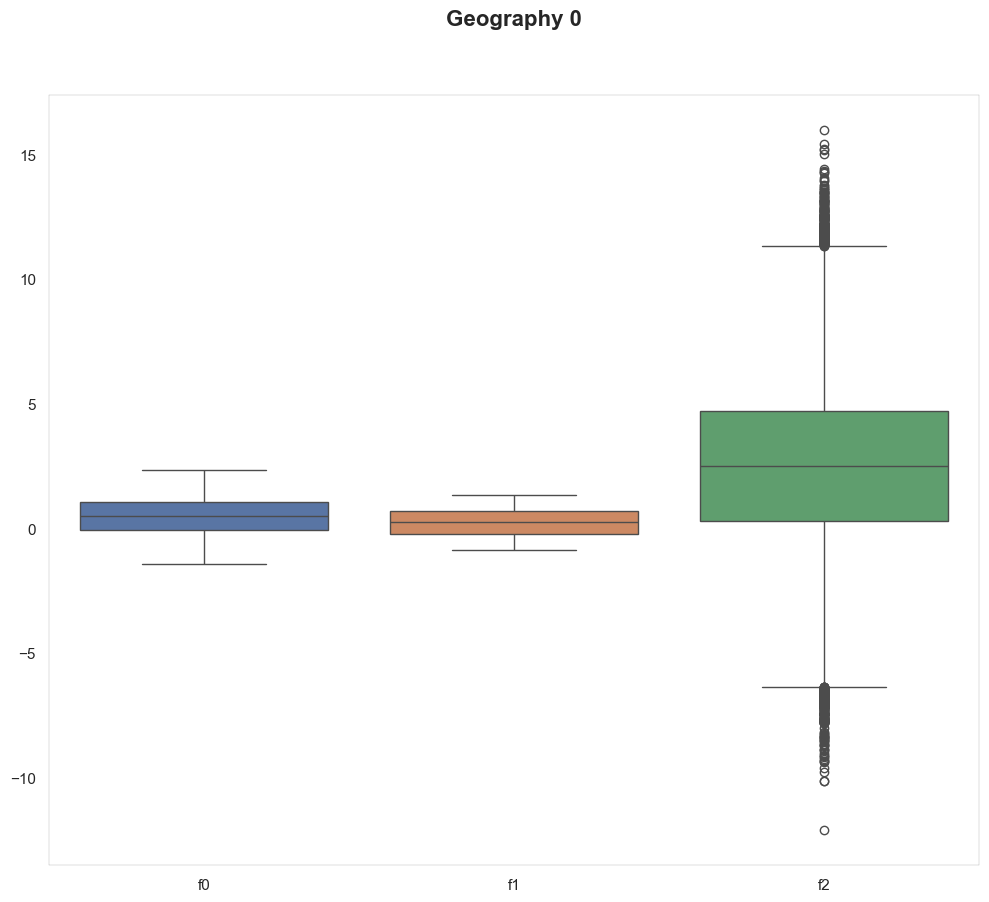

In [497]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(data=geo_data_0[['f0', 'f1', 'f2']])
ax.set_title('Geography 0', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

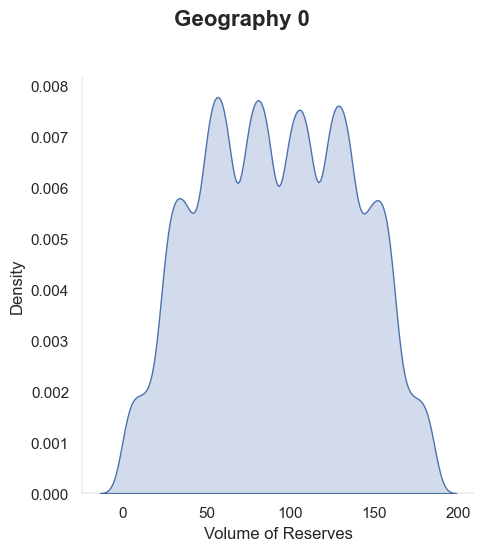

In [498]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
plt.close()
g = sns.displot(data=geo_data_0, x="product", kind="kde", legend=None, fill=True).set(xlabel='Volume of Reserves')

g.fig.suptitle('Geography 0', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

In [499]:
print('\x1B[1m' + 'Geography 1 - underlying statistics:'+ '\x1B[0m')
geo_data_1.describe()

Geography 1 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


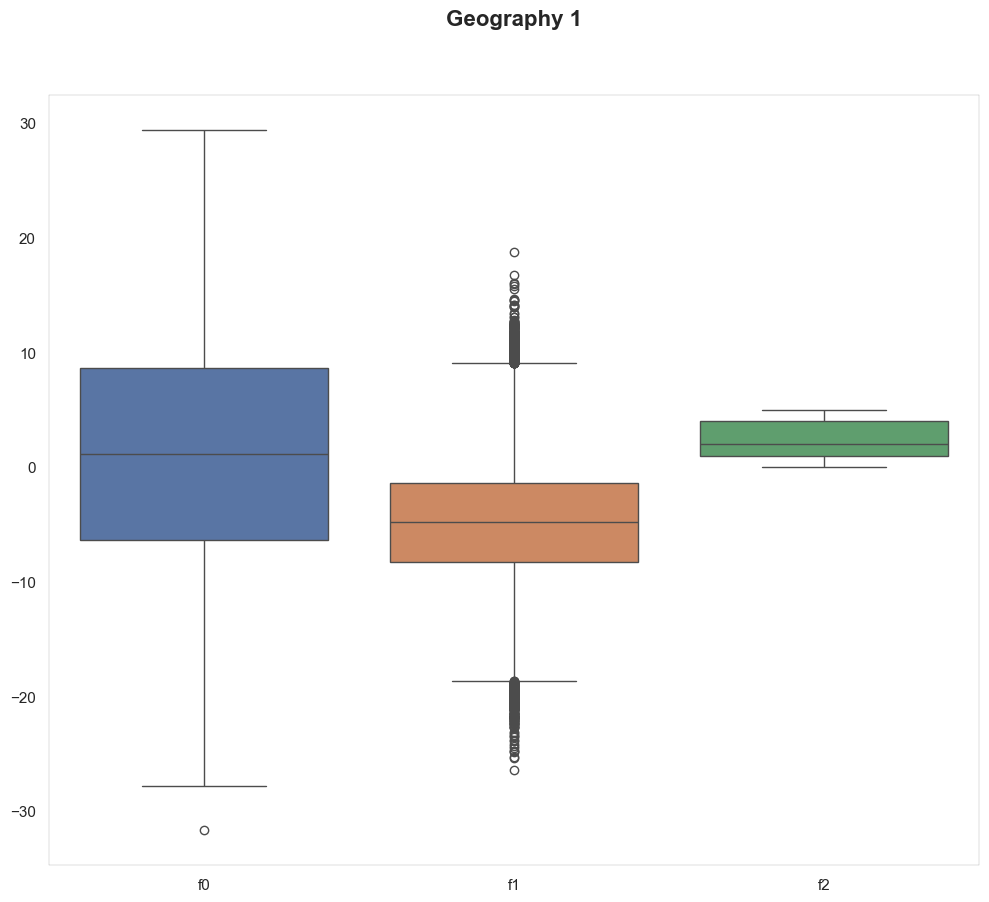

In [500]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
g = sns.boxplot(data=geo_data_1[['f0', 'f1', 'f2']], ax=ax)
ax.set_title('Geography 1', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

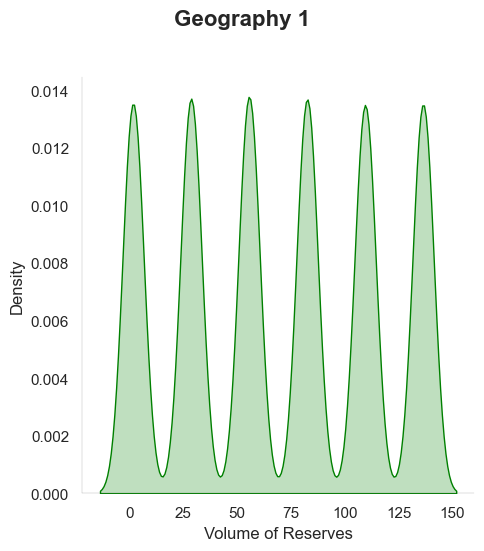

In [501]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
plt.close()
g = sns.displot(data=geo_data_1, x="product", kind="kde", legend=None, fill=True, color='green').set(xlabel='Volume of Reserves')

g.fig.suptitle('Geography 1', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

In [502]:
print('\x1B[1m' + 'Geography 2 - underlying statistics:'+ '\x1B[0m')
geo_data_2.describe()

Geography 2 - underlying statistics:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


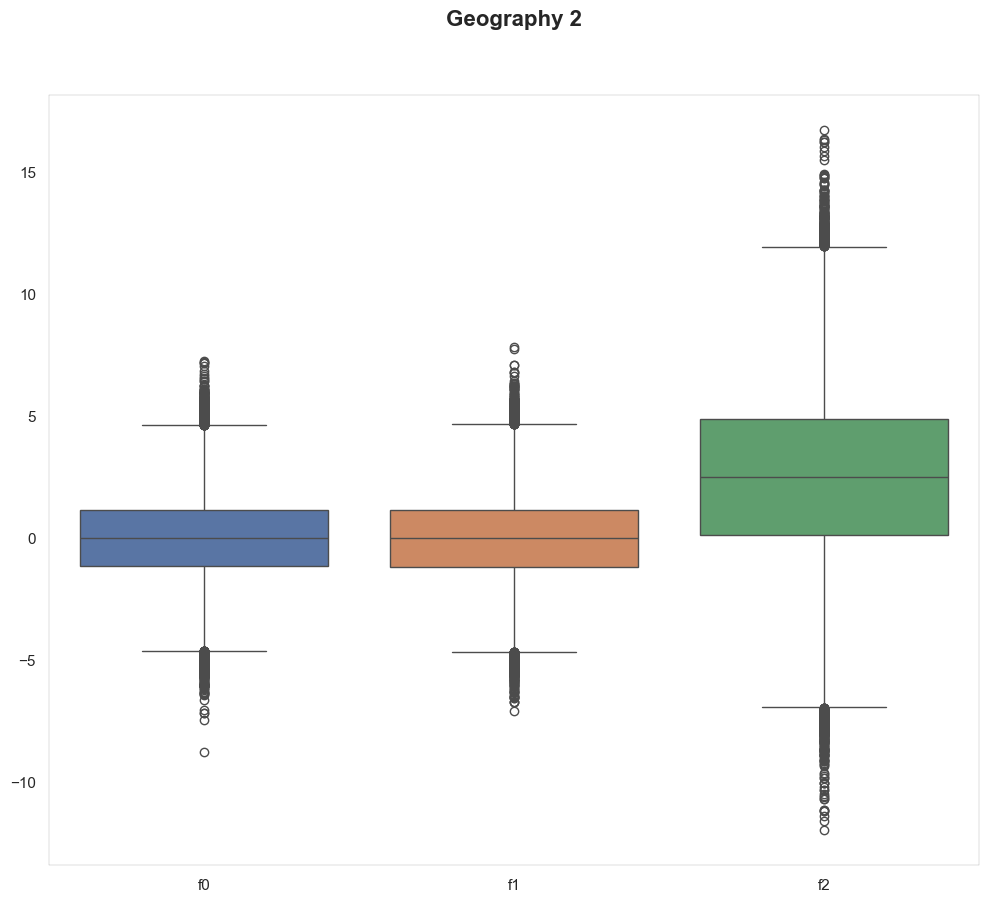

In [503]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(data=geo_data_2[['f0', 'f1', 'f2']])
ax.set_title('Geography 2', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

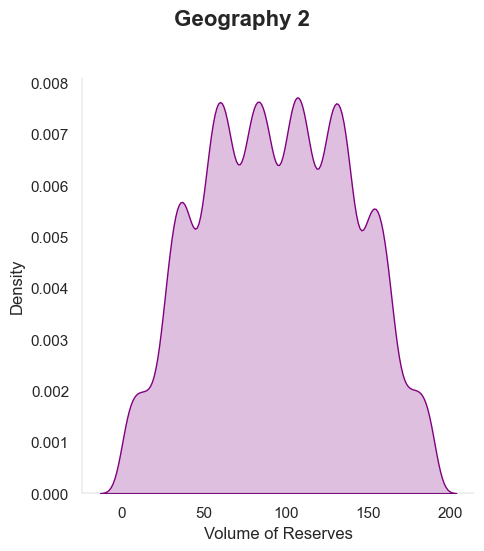

In [504]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(12, 10))
plt.close()
g = sns.displot(data=geo_data_2, x="product", kind="kde", legend=None, fill=True, color='purple').set(xlabel='Volume of Reserves')

g.fig.suptitle('Geography 2', x=0.5, y=1.1, ha='center', va='top', fontsize=16, weight='bold')

plt.show()

In [505]:
def nan_check(df):
    df_nan = pd.DataFrame(data=[df.isna().sum().tolist(), ['{:.2f}'.format(i)+'%' \
           for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
           columns=df.columns, index=['NaN Count', 'NaN Percent']).transpose()
    return df_nan.style.background_gradient(cmap='Blues', subset=['NaN Count'])

In [506]:
# nan_check(geo_data_0)

`Findings`

- The three data sets have the same amount of columns/entries and dtypes, no perceived NaN values.
    
- There are no perceived NaN values or duplicate rows.

- There are a few outliers throughout the DataFrames and features.

**Modeling**

Reproducibility

In [507]:
seed = 12345

geo_data_0

In [508]:
features_0 = geo_data_0.drop(['id','product'], axis=1) # removing redundant ('id')
target_0 = geo_data_0['product']

X_train, X_test, y_train, y_test = train_test_split(features_0,
                                                    target_0,
                                                    test_size=0.25,
                                                    random_state=seed)


In [509]:
dm = DummyRegressor()
lr = LinearRegression()
sgd = SGDRegressor(random_state=seed)
br = BayesianRidge()
eln = ElasticNet(random_state=seed)
gbr = GradientBoostingRegressor(random_state=seed)

classifiers = [('DummyRegressor', dm),('LinearRegression', lr),
               ('SGDRegressor', sgd), ('BayesianRidge', br),
               ('ElasticNet', eln),('GradientBoosting', gbr)]

In [510]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train, y_train)

    # label prediction
    y_pred = clf.predict(X_test)

    # evaluations
    scoring = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
    print('{:s} Average Cross-Val Score: {:.3f}'.format(clf_name, scoring.mean()))
    print('{:s} Average RMSE score: {:.3f}'.format(clf_name, np.mean(np.sqrt(np.abs(scoring)))))
    print('{:s} Average Prediction of Oil Reserve Volume: {:f}\n'.format(clf_name, y_pred.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


DummyRegressor Average Cross-Val Score: -1961.484
DummyRegressor Average RMSE score: 44.288
DummyRegressor Average Prediction of Oil Reserve Volume: 92.640468


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


LinearRegression Average Cross-Val Score: -1423.738
LinearRegression Average RMSE score: 37.732
LinearRegression Average Prediction of Oil Reserve Volume: 92.592568


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


SGDRegressor Average Cross-Val Score: -1427.245
SGDRegressor Average RMSE score: 37.779
SGDRegressor Average Prediction of Oil Reserve Volume: 94.900166


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


BayesianRidge Average Cross-Val Score: -1423.738
BayesianRidge Average RMSE score: 37.732
BayesianRidge Average Prediction of Oil Reserve Volume: 92.592605


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


ElasticNet Average Cross-Val Score: -1451.205
ElasticNet Average RMSE score: 38.095
ElasticNet Average Prediction of Oil Reserve Volume: 92.596719


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GradientBoosting Average Cross-Val Score: -1385.186
GradientBoosting Average RMSE score: 37.218
GradientBoosting Average Prediction of Oil Reserve Volume: 92.553898


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


`Findings`

1. Comparing our dummy model vs various regression models through iteration and scoring metrics, we find the following 1) all regressor models perform better than our dummy model, 2) our best performing model is the GradientBoostingRegressor through analyzing RMSE scores throughout (scoring leverages training data). Expecting similar performance across the other 2 geographies. 
    
2. Our best average predicted oil reserve volume comes out to about 92.55 which is very close to our initally inspected value using `describe()` in our earlier code block. Our average oil reserve was 92.50 in the data exploration phase.

In [511]:
gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

#average volume of predicted oil reserves
print('\x1B[1m' + 'Gradient Boosting Avg Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(y_pred.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - y_pred.mean()))
breakeven_0 = breakeven - y_pred.mean()

Gradient Boosting Avg Prediction of Oil Reserve Volume:
93
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
18


In [512]:
#function to format numbers into more readable instances

def revenue_format(number):
    units = ['', 'K', 'M', 'B', 'T']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.2f%s' % (number / k**magnitude, units[magnitude])


geo_data_1

In [513]:
features_1 = geo_data_1.drop(['id','product'], axis=1) # removing redundant ('id')
target_1 = geo_data_1['product']

X_train, X_test, y_train, y_test = train_test_split(features_1,
                                                    target_1,
                                                    test_size=0.25,
                                                    random_state=seed)


In [514]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train, y_train)

    # label prediction
    y_pred = clf.predict(X_test)

    # evaluations
    scoring = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
    print('{:s} Average Cross-Val Score: {:.3f}'.format(clf_name, scoring.mean()))
    print('{:s} Average RMSE score: {:.3f}'.format(clf_name, np.mean(np.sqrt(np.abs(scoring)))))
    print('{:s} Average Prediction of Oil Reserve Volume: {:f}\n'.format(clf_name, y_pred.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


DummyRegressor Average Cross-Val Score: -2108.547
DummyRegressor Average RMSE score: 45.919
DummyRegressor Average Prediction of Oil Reserve Volume: 68.858955


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


LinearRegression Average Cross-Val Score: -0.791
LinearRegression Average RMSE score: 0.890
LinearRegression Average Prediction of Oil Reserve Volume: 68.728547


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


SGDRegressor Average Cross-Val Score: -0.801
SGDRegressor Average RMSE score: 0.895
SGDRegressor Average Prediction of Oil Reserve Volume: 68.673106


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


BayesianRidge Average Cross-Val Score: -0.791
BayesianRidge Average RMSE score: 0.890
BayesianRidge Average Prediction of Oil Reserve Volume: 68.728547


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


ElasticNet Average Cross-Val Score: -49.820
ElasticNet Average RMSE score: 7.058
ElasticNet Average Prediction of Oil Reserve Volume: 68.748150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s


GradientBoosting Average Cross-Val Score: -0.514
GradientBoosting Average RMSE score: 0.717
GradientBoosting Average Prediction of Oil Reserve Volume: 68.729376


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


In [515]:
gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

#average volume of predicted oil reserves
print('\x1B[1m' + 'Gradient Boosting Avg Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(y_pred.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - y_pred.mean()))
breakeven_1 = breakeven - y_pred.mean()

Gradient Boosting Avg Prediction of Oil Reserve Volume:
69
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
42


geo_data_2

In [516]:
features_2 = geo_data_2.drop(['id','product'], axis=1) # removing redundant ('id')
target_2 = geo_data_2['product']

X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                    target_2,
                                                    test_size=0.25,
                                                    random_state=seed)


In [517]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train, y_train)

    # label prediction
    y_pred = clf.predict(X_test)

    # evaluations
    scoring = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
    print('{:s} Average Cross-Val Score: {:.3f}'.format(clf_name, scoring.mean()))
    print('{:s} Average RMSE score: {:.3f}'.format(clf_name, np.mean(np.sqrt(np.abs(scoring)))))
    print('{:s} Average Prediction of Oil Reserve Volume: {:f}\n'.format(clf_name, y_pred.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


DummyRegressor Average Cross-Val Score: -1998.072
DummyRegressor Average RMSE score: 44.700
DummyRegressor Average Prediction of Oil Reserve Volume: 95.038589


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


LinearRegression Average Cross-Val Score: -1605.272
LinearRegression Average RMSE score: 40.066
LinearRegression Average Prediction of Oil Reserve Volume: 94.965046


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


SGDRegressor Average Cross-Val Score: -1609.262
SGDRegressor Average RMSE score: 40.116
SGDRegressor Average Prediction of Oil Reserve Volume: 94.907855


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


BayesianRidge Average Cross-Val Score: -1605.272
BayesianRidge Average RMSE score: 40.066
BayesianRidge Average Prediction of Oil Reserve Volume: 94.965058


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


ElasticNet Average Cross-Val Score: -1606.088
ElasticNet Average RMSE score: 40.076
ElasticNet Average Prediction of Oil Reserve Volume: 94.969257


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


GradientBoosting Average Cross-Val Score: -1422.828
GradientBoosting Average RMSE score: 37.720
GradientBoosting Average Prediction of Oil Reserve Volume: 95.012344


In [518]:
gbr = GradientBoostingRegressor(random_state=seed)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

#average volume of predicted oil reserves
print('\x1B[1m' + 'Gradient Boosting Avg Prediction of Oil Reserve Volume:'+ '\x1B[0m')
print(round(y_pred.mean())) #close to the value under our previous view into the data sets statistics

#comparing the above to the breakeven point
product_rev = 4500
budget = 100000000
breakeven = round(int(budget/product_rev)/200)
print('\x1B[1m' + 'Average Breakeven Point:'+ '\x1B[0m')
print(breakeven)


print('\x1B[1m' + 'Difference between Average Volume Prediction and Average Breakeven:'+ '\x1B[0m')
print(round(breakeven - y_pred.mean()))
breakeven_2 = breakeven - y_pred.mean()

Gradient Boosting Avg Prediction of Oil Reserve Volume:
95
Average Breakeven Point:
111
Difference between Average Volume Prediction and Average Breakeven:
16


**`Findings`**

- When comparing the RMSE metrics, we see the lowest delta out of Geography 1 with the highest predicted oil reserve value coming out of Geography 2.  
    
- Average predictions for oil well volume are quite aligned to our initial observations when exploring the data sets.

- The initial conclusion from the break-even analysis is that we are set to lose some oil reserve volume in all Regions since break-even is above all the predicted volume amounts, w/o any bootstrapping or the selection of tops predictions. Meaning that as of right now, the model isn't as helpful just yet.

**Profit and Risk Calculation**

In [519]:
def refined_profit_calc(target, predictions, count):
    """Function to calculate profit.
    Leverages a set of selected oil wells and model predictions.
    Will need to pick the wells with the highest predictions inturn. 
    """
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    budget = 100000000
    product_rev = 4500
    return (selected.sum() * product_rev) - budget

In [520]:
def geography_revenue(df):
    """Function meant to help in the calculation of revenue per Geography.
    Utilizes the most optimal model for the project.
    Returns our target test and target prediction in Series form.
    """
    X = df.drop(['id','product'], axis=1)
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.25,
                                                        random_state=seed)
    gbr = GradientBoostingRegressor(random_state=seed)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    
    y_test_series = pd.Series(y_test).reset_index(drop=True)
    y_pred_series = pd.Series(y_pred).reset_index(drop=True)
    
    return y_test_series, y_pred_series

In [521]:
def bootstrap(tgt, pred, count):
    """Bootstrapping function to aid in finding the profit distribution.
    Called for each Geography.
    """
    pred_sorted = pred.reset_index(drop=True).sort_values(ascending=False)
    selected = tgt.reset_index(drop=True)[pred_sorted.index][:count]
    budget = 100000000
    product_rev = 4500
    return (selected.sum() * product_rev) - budget

Geography 0

In [522]:
target, predictions = geography_revenue(geo_data_0)

print('\x1B[1m' + 'Total Profit per Geography (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 0:', revenue_format(refined_profit_calc(target, predictions, 200)))
print('')
print('\x1B[1m' + 'Target Volume of Reserves (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 0:', revenue_format(target[predictions.index][:200].sum()))

Total Profit per Geography (Top 200 Oil Well Predictions):
Geo. 0: 33.96M

Target Volume of Reserves (Top 200 Oil Well Predictions):
Geo. 0: 18.18K


Distribution and Average Profit


Lower Quantile: -485476.6514413397
Upper Quantile: 9669299.694798695
Mean: 4774717.148136213
95% confidence interval: (4610864.7056488795, 4938569.590623547)

Average Profit for Geography 0:
4.77M

Profit Distribution for Geography 0:


/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/ipykernel_1331/3099804747.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(profit_0, color="darkcyan",


Text(0.5, 1.05, 'Geography 0')

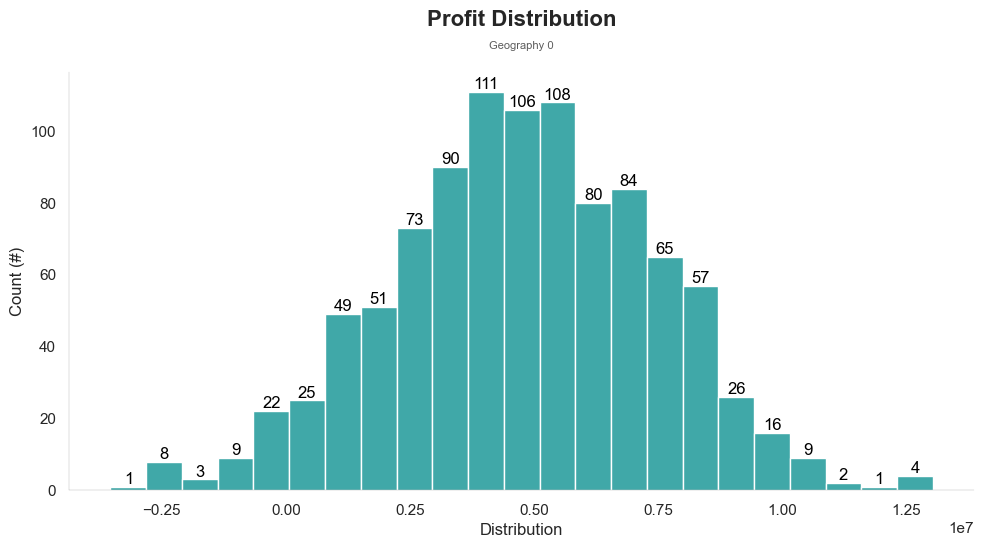

In [523]:
#confidence intervals/quantiles
state = np.random.RandomState(12345)

profit_0 = []
for i in range(1000):
    target_subsample_0 = target.sample(n=500,replace=True, random_state=state)
    pred_subsample_0 = predictions[target_subsample_0.index]
    profit_0.append(bootstrap(target_subsample_0, pred_subsample_0, 200))

profit_0 = pd.Series(profit_0)
neg_profit_0 = profit_0.where(profit_0 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_0)-1, loc=profit_0.mean(), scale=profit_0.sem())

#quantile view
lower = profit_0.quantile(0.025)
upper = profit_0.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_0.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_0 = profit_0.mean()
print('\x1B[1m' + 'Average Profit for Geography 0:'+ '\x1B[0m')
print(revenue_format(average_profit_0))
print('')

print('\x1B[1m' + 'Profit Distribution for Geography 0:'+ '\x1B[0m')
fig, ax = plt.subplots(figsize=(10, 8))
plt.close()
g = sns.displot(profit_0, color="darkcyan",
                height=5,
                aspect=2,
                palette='mako',
                )

ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(v.get_height())}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', color='black')

g.set(xlabel='Distribution', ylabel='Count (#)')
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Profit Distribution', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Geography 0', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

Geography 1

In [524]:
target, predictions = geography_revenue(geo_data_1)

print('\x1B[1m' + 'Total Profit per Geography (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 1:', revenue_format(refined_profit_calc(target, predictions, 200)))
print('')
print('\x1B[1m' + 'Target Volume of Reserves (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 1:', revenue_format(target[predictions.index][:200].sum()))

Total Profit per Geography (Top 200 Oil Well Predictions):
Geo. 1: 24.15M

Target Volume of Reserves (Top 200 Oil Well Predictions):
Geo. 1: 13.35K


Distribution and Average Profit


Lower Quantile: 780508.107517418
Upper Quantile: 8629520.602637246
Mean: 4611744.150273514
95% confidence interval: (4488526.823524855, 4734961.477022173)

Average Profit for Geography 1:
4.61M

Profit Distribution for Geography 1:


Text(0.5, 1.05, 'Geography 1')

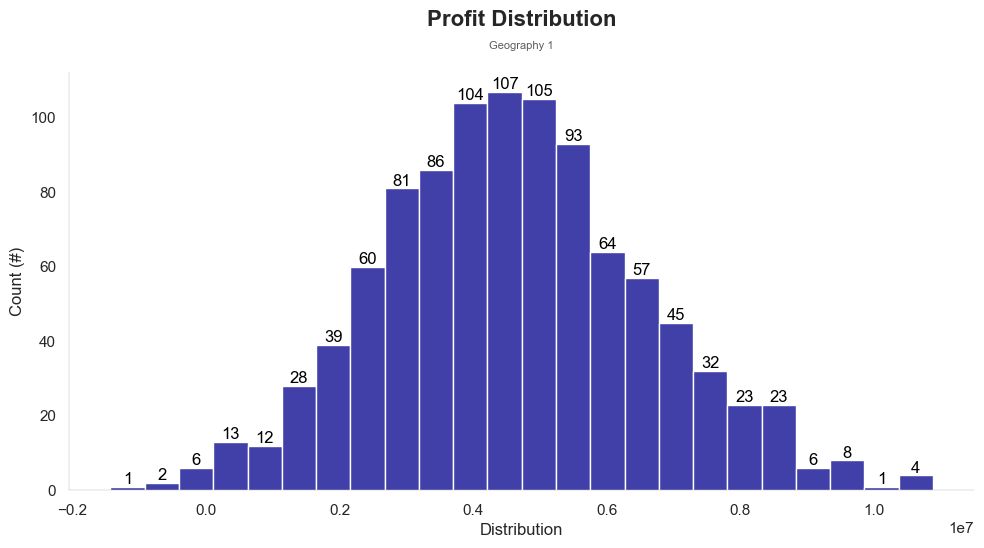

In [525]:
#confidence intervals/quantiles
profit_1 = []
for i in range(1000):
    target_subsample_1 = target.sample(n=500,replace=True, random_state=state)
    pred_subsample_1 = predictions[target_subsample_1.index]
    #print(pred_subsample)
    profit_1.append(bootstrap(target_subsample_1, pred_subsample_1, 200))

profit_1 = pd.Series(profit_1)
neg_profit_1 = profit_1.where(profit_1 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_1)-1, loc=profit_1.mean(), scale=profit_1.sem())

#quantile view
lower = profit_1.quantile(0.025)
upper = profit_1.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_1.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_1 = profit_1.mean()
print('\x1B[1m' + 'Average Profit for Geography 1:'+ '\x1B[0m')
print(revenue_format(average_profit_1))
print('')

print('\x1B[1m' + 'Profit Distribution for Geography 1:'+ '\x1B[0m')
fig, ax = plt.subplots(figsize=(10, 8))
plt.close()
g = sns.displot(profit_1, color="darkblue", height=5, aspect=2)

ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(v.get_height())}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', color='black')

g.set(xlabel='Distribution', ylabel='Count (#)')
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Profit Distribution', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Geography 1', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

Geography 2

In [526]:
target, predictions = geography_revenue(geo_data_2)

print('\x1B[1m' + 'Total Profit per Geography (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 2:', revenue_format(refined_profit_calc(target, predictions, 200)))
print('')
print('\x1B[1m' + 'Target Volume of Reserves (Top 200 Oil Well Predictions):'+ '\x1B[0m')
print('Geo. 2:', revenue_format(target[predictions.index][:200].sum()))

Total Profit per Geography (Top 200 Oil Well Predictions):
Geo. 2: 35.81M

Target Volume of Reserves (Top 200 Oil Well Predictions):
Geo. 2: 18.92K


Distribution and Average Profit


Lower Quantile: 1636155.6288792216
Upper Quantile: 12045340.916809265
Mean: 6776814.7397297975
95% confidence interval: (6610893.807545693, 6942735.671913902)

Average Profit for Geography 2:
6.78M

Profit Distribution for Geography 2:


Text(0.5, 1.05, 'Geography 2')

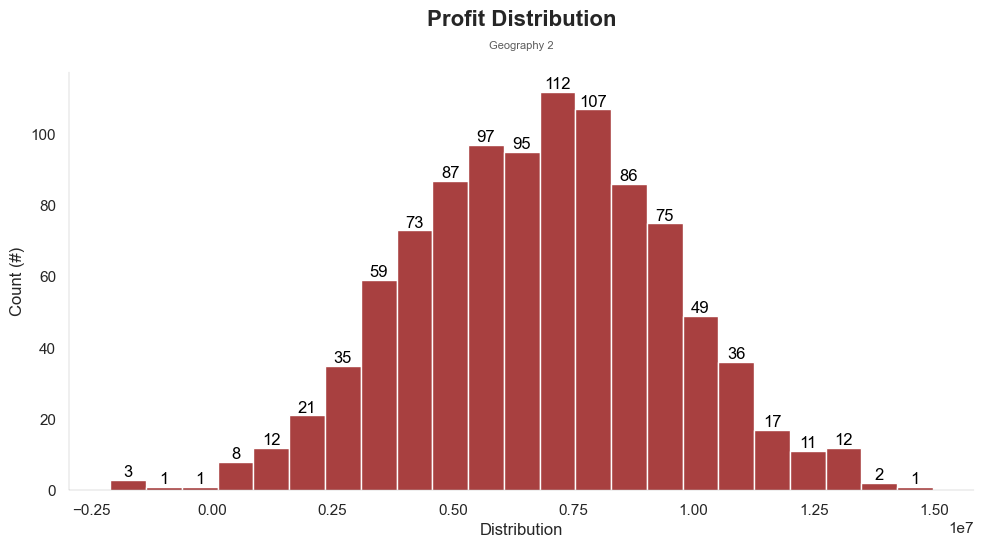

In [527]:
#confidence intervals/quantiles
profit_2 = []
for i in range(1000):
    target_subsample_2 = target.sample(n=500, replace=True, random_state=state)
    pred_subsample_2 = predictions[target_subsample_2.index]
    profit_2.append(bootstrap(target_subsample_2, pred_subsample_2, 200))

profit_2 = pd.Series(profit_2)
neg_profit_2 = profit_2.where(profit_2 < 0).count()

#confidence interval target
confidence_interval = st.t.interval(confidence=0.95, df=len(profit_2)-1, loc=profit_2.mean(), scale=profit_2.sem())

#quantile view
lower = profit_2.quantile(0.025)
upper = profit_2.quantile(0.975)
print('')
print('\x1B[1m' + 'Lower Quantile:'+ '\x1B[0m', lower)
print('\x1B[1m' + 'Upper Quantile:'+ '\x1B[0m', upper)
print('\x1B[1m' + 'Mean:'+ '\x1B[0m', profit_2.mean())
print('\x1B[1m' + '95% confidence interval:'+ '\x1B[0m', confidence_interval)


print('')
average_profit_2 = profit_2.mean()
print('\x1B[1m' + 'Average Profit for Geography 2:'+ '\x1B[0m')
print(revenue_format(average_profit_2))
print('')

print('\x1B[1m' + 'Profit Distribution for Geography 2:'+ '\x1B[0m')
fig, ax = plt.subplots(figsize=(10, 8))
plt.close()
g = sns.displot(profit_2, color="darkred", height=5, aspect=2)

ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(v.get_height())}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', color='black')

g.set(xlabel='Distribution', ylabel='Count (#)')
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Profit Distribution', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Geography 2', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

`Findings`

- Geography 2 brings in the most revenue taking into account cost which is a profit of about 36 mln, close to 2 mln more than the next geography. Target reserve volume varies across the regions with Geography 2 having the highest overall target volume followed by Geography 0.

- If we are to pick the highest estimated values/highest profit from the predictions - the suggestion would be to focus on Geography 2. This geography has both a slightly lower delta between average oil reserve volume prediction and the average break-even point compared to the other two, it is predicted to bring a higher overall profit when taking the top 200 oil wells into account.

- The maximum profit values show values if we're lucky enough that all top 200 wells in the respective geographies are contained in the small samples of 500 random locations.

**Risk of Losses:**

In [528]:
#Loss = negative profit, calculate it as a probability and then express as a percentage.

print(f"Risk of Losses for Region 0: {(neg_profit_0/len(profit_0))*100}%")

print(f"Risk of Losses for Region 1: {(neg_profit_1/len(profit_1))*100}%")

print(f"Risk of Losses for Region 2: {(neg_profit_2/len(profit_2))*100}%")

# select regions with the risk of losses lower than 2.5%

Risk of Losses for Region 0: 4.1000000000000005%
Risk of Losses for Region 1: 0.7000000000000001%
Risk of Losses for Region 2: 0.5%


# Conclusion

We analyzed each geography and found variations across feature values (magnitudes) with all features being constant across the DataFrames. We did not merge the geographies into one DataFrame as per instructions (finding the best geography for the wells) but may have done with scaling and some feature engineering to be able to identify the geographies. 

- There were outliers in each of the DataFrames, but they did not have 'crazy' variances (within close bounds of the quantiles). We could have employed DF cleaning and removed the outliers.

Our next step was deploying various regression models in order to find the most optimal one via RMSE score comparisons. Gradient Boosting Regression initially gave us some of the best scores as well as close predictions in oil reserves (validating through our initial descriptive statistics for each geography). This was consistent through all the geographies. We did not find a need to incorporate any hyperparameter tuning but the option was there.

- This followed break-even analysis per our predicted oil well reserves to get a sense as to how much our delta (our difference) was. All three geographies had some limitations as none of them, on average, were able to hit the break-even mark but some got closer than others.

- Sorting for our top 200 wells for each geography, we were able to see the revenue and oil well volume targets. Geography 2 performed the best with Geography 0 not too far behind. 

Next, leveraging bootstrapping to find the distribution of profit, we were able to get a sense of quantile, confidence interval and average profit data per geography. As well as the overall profit distribution for each (all followed a normal distribution). 

- Our initial findings were reinforced, Geography 2 was a better performing region compared to the others. 

- Lastly, to get closer insights into the risk of losses, we computed said risk of loss for each geography in percentage terms. Keeping only those with ratios under 2.5% under consideration for the project. This removed our worst performing geography, Geography 0. 

After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

Overall, through careful analyses per geography and taking various metrics into consideration, we were able to hone in on the geography that the client should focus for new well development - being Geography 2. Geography performed the best throughout and the more analysis we took on for this geography the more we were comfortable with the selection. 